In [4]:
from pathlib import Path

import seaborn_image as isns
import numpy as np
import torch
import wandb
from surface_distance import compute_surface_dice_at_tolerance, compute_surface_distances
from tqdm import tqdm

from uda import CC359, CC359Config, HParams, VAEConfig
from uda.metrics import dice_score
from uda.models.modeling_vae import VAE
from uda.utils import reshape_to_volume
from torch.utils.data import DataLoader

isns.set_image(origin="upper")

/tmp/conda/envs/uda/lib/python3.9/site-packages/seaborn_image/_context.py:128: UserWarning: Trying to register the cmap 'deep' which already exists.
  register_cmap(name=cmap, cmap=cmap_mpl)


In [5]:
run_id = "1r1k4mdd"
project = "UDA-CC359-VAE"
data_dir = Path("/tmp/data/CC359")
files_dir = Path("/tmp/files")

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

wandb.restore("config/cc359.yaml", f"tiser/{project}/{run_id}", root=files_dir, replace=True)
wandb.restore("config/hparams.yaml", f"tiser/{project}/{run_id}", root=files_dir, replace=True)
wandb.restore("config/vae.yaml", f"tiser/{project}/{run_id}", root=files_dir, replace=True)
wandb.restore("best_model.pt", f"tiser/{project}/{run_id}", root=files_dir, replace=True)

vae_config: VAEConfig = VAEConfig.from_file(files_dir / "config/vae.yaml")
dataset_config: CC359Config = CC359Config.from_file(files_dir / "config/cc359.yaml")
hparams: HParams = HParams.from_file(files_dir / "config/hparams.yaml")

print(f"Evaluating run {run_id}\n")

dataset = CC359(data_dir, dataset_config)
data_loader = DataLoader(dataset.targets, batch_size=hparams.val_batch_size, shuffle=False)

model = VAE.from_pretrained(files_dir / "best_model.pt", vae_config)
model.eval().to(device)

with torch.no_grad():
    preds, targets = [
        *zip(*[(model(x.to(device))[0].sigmoid().round().cpu(), x) for x in tqdm(data_loader, desc="Predicting")])
    ]

preds = torch.cat(preds).numpy()
targets = torch.cat(targets).numpy()

preds = reshape_to_volume(preds, dataset.imsize, dataset.patch_size)
targets = reshape_to_volume(targets, dataset.imsize, dataset.patch_size)
data = reshape_to_volume(dataset.data, dataset.imsize, dataset.patch_size)


Using device: cuda:0


ValueError: File best_model.pt not found in tiser/UDA-CC359-VAE/1r1k4mdd.

/tmp/conda/envs/uda/lib/python3.9/site-packages/seaborn_image/_context.py:128: UserWarning: Trying to register the cmap 'deep' which already exists.
  register_cmap(name=cmap, cmap=cmap_mpl)


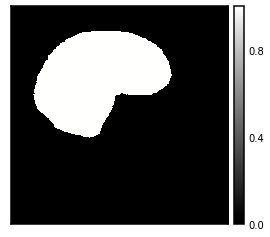

In [11]:
isns.imshow(preds[0, 96], cmap='gray');

In [16]:
import imageio

def write_tiff(array: np.ndarray, path: Path) -> None:
    array = (array * 255).astype(np.uint8)
    imageio.mimwrite(path, array)

In [17]:
output_dir = Path("/tmp/output")
output_dir.mkdir(exist_ok=True)

write_tiff(data[0], output_dir / "test_data_0_3d.tiff")
write_tiff(targets[0], output_dir / "test_mask_0_3d.tiff")
write_tiff(preds[0], output_dir / "test_pred_0_3d.tiff")